# Linear Bivariate BMM with SAMBA toy models : cdf mixing

The best way to learn Taweret is to use it. You can run, modify and experiment with this notebook [here.](https://mybinder.org/v2/gh/danOSU/Taweret/c2d8fd3ce3d74a5891d51adb5afc0afa0b503127?urlpath=lab%2Ftree%2Fdocs%2Fsource%2Fnotebooks%2FLinear_BMM_with_cdf_function_for_SAMBA_models.ipynb)


This notebook shows how to use the Bayesian model mixing package **Taweret** for a toy problem. 

**Author : Dan Liyanage**

Date : 11/10/2022

More about SAMBA toy models can be found in [Uncertainties here, there, and everywhere: interpolating between small- and large-g expansions using Bayesian Model Mixing](https://arxiv.org/abs/2206.04116)



In [1]:
import sys

# You will have to change the following imports depending on where you have 
# the packages installed

# If using binder please uncomment the followings.
#sys.path.append("/home/jovyan/")
#sys.path.append("/home/jovyan/subpackages/SAMBA")

sys.path.append("/Users/dananjayaliyanage/temp2/Taweret")
sys.path.append("/Users/dananjayaliyanage/temp2/Taweret/subpackages/SAMBA")

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
# To define priors. (uncoment if not using default priors)
import bilby

# For other operations
import numpy as np

## 1. Get toy models and the pseudo-experimental data

In [2]:
# Toy models from SAMBA
from Taweret.models import samba_models as toy_models

m1 = toy_models.Loworder(2, 'uninformative')
m2 = toy_models.Highorder(2, 'uninformative')
truth = toy_models.TrueModel()
exp = toy_models.Data()

In [3]:
g = np.linspace(0.1, 0.6, 10)
plot_g = np.linspace(0.01,1,100)
m1_prediction = m1.evaluate(plot_g)
m2_prediction = m2.evaluate(plot_g)
true_output = truth.evaluate(plot_g)
exp_data= exp.evaluate(g,error = 0.01)

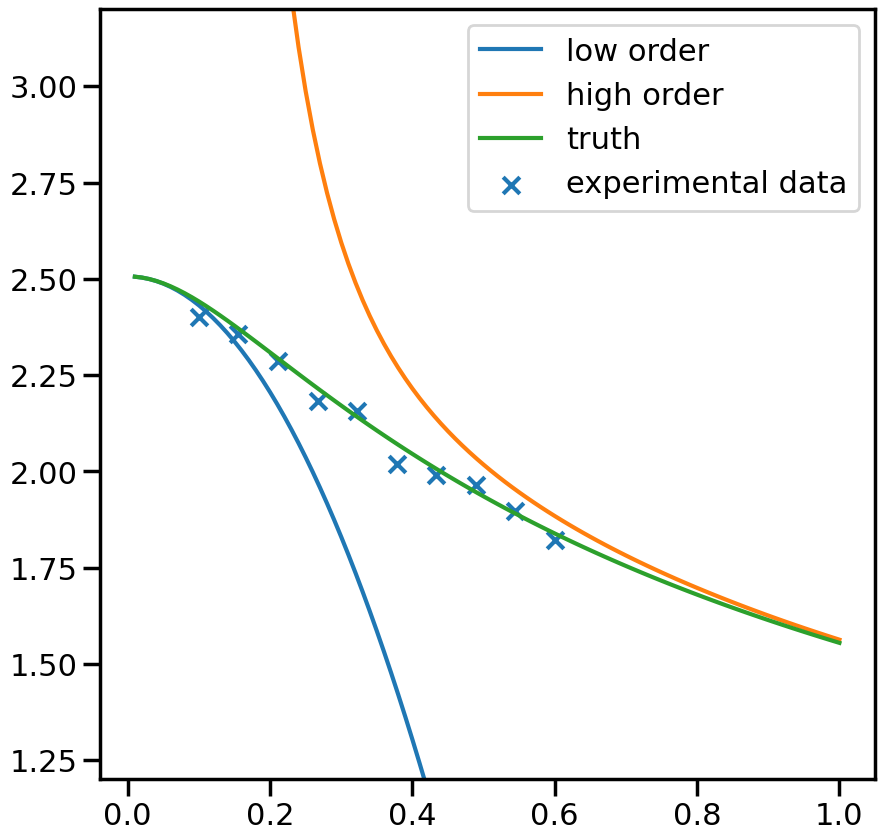

In [6]:

fig, ax_f = plt.subplots(figsize=(10,10))
ax_f.plot(plot_g, m1_prediction[0].flatten(), label='low order')
ax_f.plot(plot_g, m2_prediction[0].flatten(), label='high order')
ax_f.plot(plot_g, true_output[0], label='truth')
ax_f.scatter(g,exp_data[0], marker='x', label='experimental data')
ax_f.set_ylim(1.2,3.2)
ax_f.legend()

##  2. Choose a Mixing method

In [7]:
# Mixing method
from Taweret.mix.bivariate_linear import BivariateLinear as BL

models= {'low_order':m1,'high_order':m2}
mix_model = BL(models_dic=models, method='cdf') 

cdf mixing function has 2                   free parameter(s)
To change the prior use `set_prior` method


In [8]:
#uncoment to change the prior from the default
priors = bilby.core.prior.PriorDict()
priors['cdf_0'] = bilby.core.prior.Uniform(-20,20, name="cdf_0")
priors['cdf_1'] = bilby.core.prior.Uniform(-20,20, name="cdf_1")
mix_model.set_prior(priors)

{'cdf_0': Uniform(minimum=-20, maximum=20, name='cdf_0', latex_label='cdf_0', unit=None, boundary=None),
 'cdf_1': Uniform(minimum=-20, maximum=20, name='cdf_1', latex_label='cdf_1', unit=None, boundary=None)}

## 3. Train to find posterior

In [9]:
mix_model.prior

{'cdf_0': Uniform(minimum=-20, maximum=20, name='cdf_0', latex_label='cdf_0', unit=None, boundary=None),
 'cdf_1': Uniform(minimum=-20, maximum=20, name='cdf_1', latex_label='cdf_1', unit=None, boundary=None)}

In [13]:
y_exp = np.array(exp_data[0]).reshape(1,-1)
y_err = np.array(exp_data[1]).reshape(1,-1)
# The parameters are set to minimum values for computational ease.
# You should increase the ntemps, nwalkers and nsamples and see
# if your results are changing. If so keep increasing them
# until convergence of results. 

kwargs_for_sampler = {'sampler': 'ptemcee',
                    'ntemps': 5,
                    'nwalkers': 50,
                    'Tmax': 100,
                    'burn_in_fixed_discard': 50,
                    'nsamples': 2000,
                    'threads': 6,
                    'printdt': 60}

result = mix_model.train(x_exp=g, y_exp=y_exp, y_err=y_err, outdir = 'outdir/samba_bivariate', 
label='cdf_mix', kwargs_for_sampler=kwargs_for_sampler)

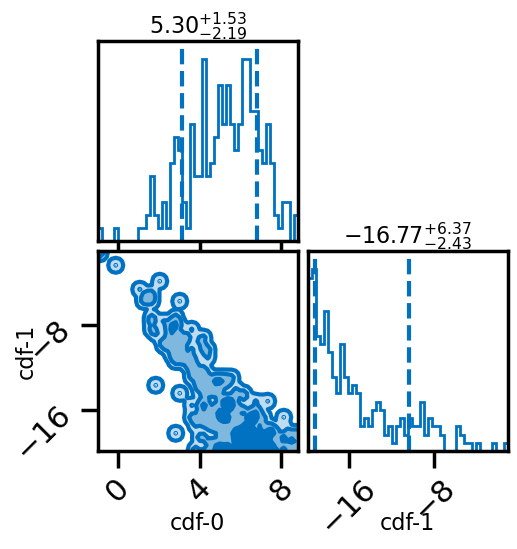

In [14]:
# Posterior of the mixing parameters. 
result.plot_corner()

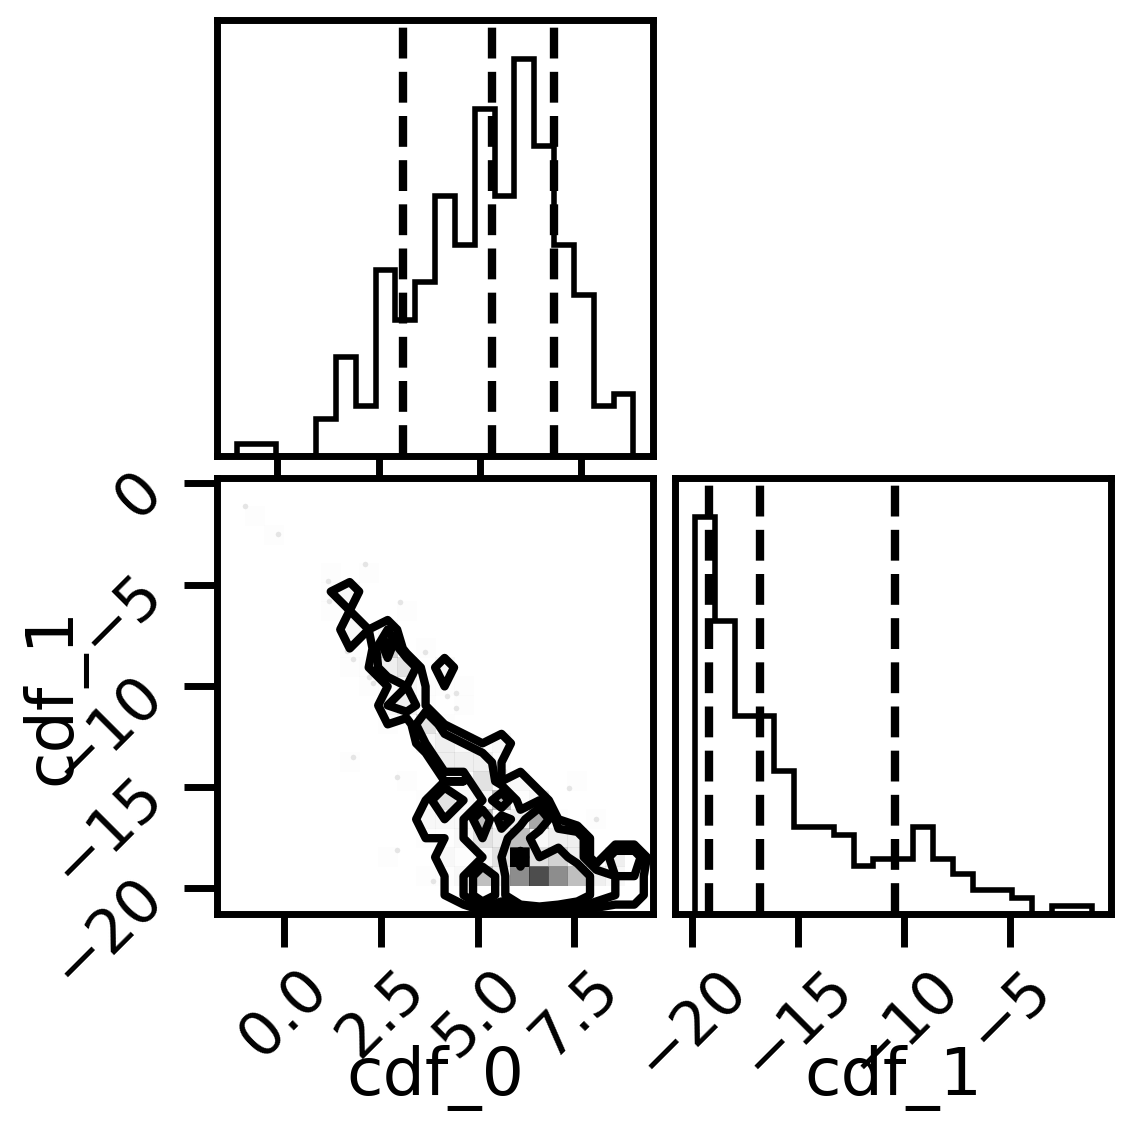

In [15]:
#corner plots
import corner
fig, axs = plt.subplots(2,2, figsize=(6,6), dpi=200)
corner.corner(mix_model.posterior,labels=['cdf_0','cdf_1'],quantiles=[0.16, 0.5, 0.84],fig=fig)
plt.show()

## 4. Predictions

In [16]:
_,mean_prior,CI_prior, _ = mix_model.prior_predict(plot_g, CI=[5,20,80,95])
_,mean,CI, _ = mix_model.predict(plot_g, CI=[5,20,80,95])

(10000, 2)
using provided samples instead of posterior


In [17]:
per5, per20, per80, per95 = CI
prior5, prior20, prior80, prior95 = CI_prior

In [18]:
# Map value prediction for the step mixing function parameter
map_prediction = mix_model.evaluate(mix_model.map, plot_g)

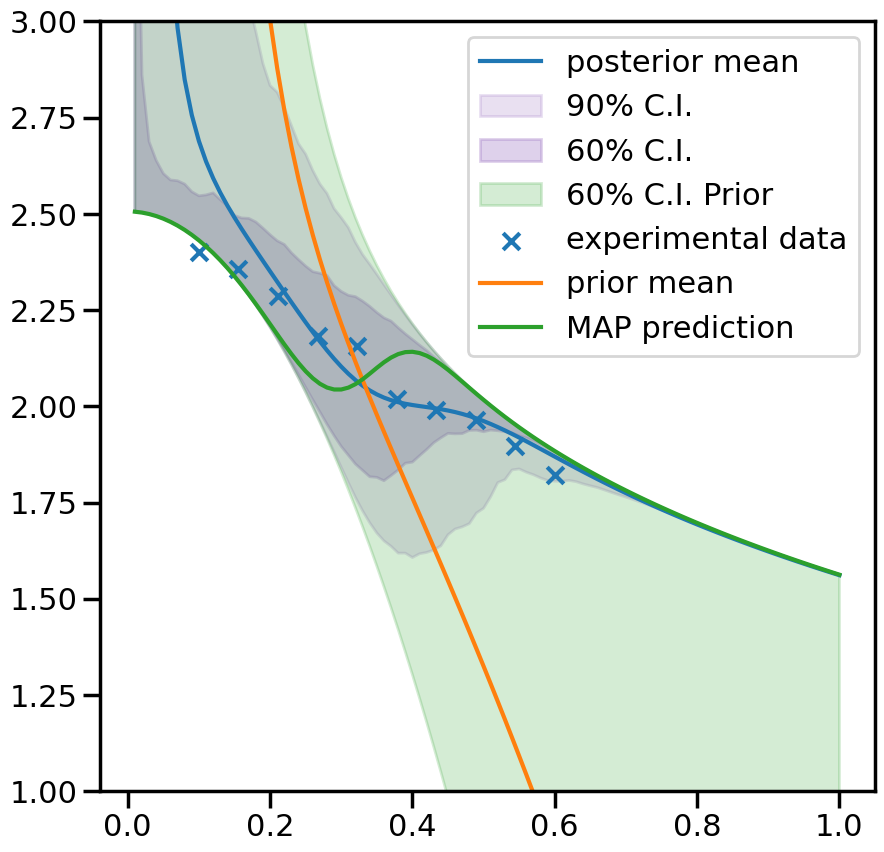

In [20]:
%matplotlib inline
sns.set_context('poster')
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(plot_g, mean.flatten(), label='posterior mean')
ax.fill_between(plot_g,per5.flatten(),per95.flatten(),color=sns.color_palette()[4], alpha=0.2, label='90% C.I.')
ax.fill_between(plot_g,per20.flatten(),per80.flatten(), color=sns.color_palette()[4], alpha=0.3, label='60% C.I.')
ax.fill_between(plot_g,prior20.flatten(),prior80.flatten(),color=sns.color_palette()[2], alpha=0.2, label='60% C.I. Prior')
ax.scatter(g,exp_data[0], marker='x', label='experimental data')
ax.plot(plot_g, mean_prior.flatten(), label='prior mean')
ax.plot(plot_g, map_prediction.flatten(), label='MAP prediction')
ax.set_ybound(1,3)
ax.legend()